# Exploratory Data Analysis 
##         -- Children's Imagined Future and its association with socioeconomic status

## Background 

“Imagine you are now 25 years old. Write about the life you are leading, your interests, your home life and your work at the age of 25”. As a part of a longitudinal study on individuals born in 1958, over 10,000 11-year-old children in the UK were asked to write an essay given the instruction above (Center for Longitudinal Studies (CLS) | 1958 National Child Development Study). Their families’ demographic information, including socioeconomic status (SES) related items (e.g., father’s occupation), was recorded. At the age of 42, they participated in another sweep of the study, which collected information including their income range. 

One study examined this corpus and themes of children’s imagined future. With selected sample and a qualitative approach, it identified a wide range of themes, including marriage, family members, occupation, money, domestic life, vacations, leisure activities and animals. Although the children rarely described their future in terms of status, researchers discovered that high SES children are more likely to write about imaginations characterizing high-prestige lifestyles (e.g. large house, fancy vehicle and overseas vacation) (Elliott, 2010).

So far, no existing literature using this corpus has investigated this relationship of SES and children’s writing with a machine learning/NLP approach. Thus, I am here to fill the gap and discover new knowledge:). 

## Data 

We (my collaborator Dr. Holly Engstrom and I) obtained the longitudinal data at CLS' data access application portal. We first selected the age-11 and age-42 waves as our data, which contain information on:
1. children's essays
2. children's father's occupation
3. whether the family experienced financial hardship
4. weekly income at the age of 42.  

We had put enormous effort to clean and preprocess the data, including manually correcting all the misspellings in the essays. The data after processing is saved in full_data.csv under the **[current repository](https://github.com/h-karyn/ImaginedFutureAndSocioeconomics)**. 

## Data Overview    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read data 
data_df = pd.read_csv('full_data.csv') 
data_df.shape

(18567, 13)

In [3]:
# get an overview of the top-n rows/samples
data_df.head()

,ID,file_name,original,corrected,misspellings,readable?,RA_name,completed?,word_count,father,mother,financial,pay_per_week
0,N10001N,B771-780,Today is my 25th birthday and I am in hospital...,Today is my 25th birthday and I am in hospital...,10.0,yes,Anika,yes,306.0,2.0,-1.0,2.0,237.25
1,N10002P,J1-10,The dog pounded up at me when i reached for he...,The dog pounded up at me when i reached for he...,9.0,yes,Andrea,yes,200.0,-1.0,-1.0,-1.0,NaN
2,N10003Q,J1-10,I would get married and be a swimming instruct...,I would get married and be a swimming instruct...,4.0,yes,Andrea,yes,268.0,3.0,6.0,1.0,NaN
3,N10004R,A821-830,When I am 25 years old. I hop that I will be m...,When I am 25 years old. I hope that I will be ...,23.0,yes,Manson,yes,169.0,2.0,8.0,2.0,221.25
4,N10005S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,6.0,2.0,NaN


## Data Cleaning

Since column file_name, original, misspellings, RA_name, completed?, word_count, and mother are not revalent to our analysis, I will drop those columns. 

In [4]:
# drop irrelevant columns
data_df = data_df.drop(['file_name', 'original', 'misspellings', 'word_count','RA_name', 'completed?', 'mother'], axis=1)
data_df.head(3)

,ID,corrected,readable?,father,financial,pay_per_week
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25
1,N10002P,The dog pounded up at me when i reached for he...,yes,-1.0,-1.0,NaN
2,N10003Q,I would get married and be a swimming instruct...,yes,3.0,1.0,NaN


In [5]:
# drop rows with missing values
data_df = data_df.dropna()

data_df.shape

(4843, 6)

Clean the 'readable?' column

In [6]:
# turn 'readable?' to lowercase
data_df['readable?'] = data_df['readable?'].str.lower()

# check the unique values
print(data_df['readable?'].unique())

# replace 'yexs' and 'yea' with 'yes'
data_df['readable?'] = data_df['readable?'].replace(['yexs', 'yea'], 'yes')

# check the unique values again
print(data_df['readable?'].unique())

# drop rows with 'no'
data_df = data_df[data_df['readable?'] == 'yes']

data_df.shape

['yes' 'no' 'yexs' 'yea']
['yes' 'no']


(4720, 6)

In [7]:
# preview the data
data_df.head(3) 

,ID,corrected,readable?,father,financial,pay_per_week
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00


## Data Preprocessing

In this data set, we label high SES as 1 and low SES as 2: * father’s occupation is coded as: 1 - non-manual; 2 - manual; * financial hardship is coded as: 1 - No; 2 - Yes;

Combination of father’s occupation and financial hardship: * 1 - father had a non-manual job & no financial hardship. * 2 - father had a manual job & no financial hardship. * 3 - father had a non-manual job & financial hardship. * 4 - father had a manual job & financial hardship.

In [8]:
# Define a function to apply the conditions
def combine_columns(row):
    if row['father'] == 1 and row['financial'] == 1:
        return 1
    elif row['father'] == 2 and row['financial'] == 1:
        return 2
    elif row['father'] == 1 and row['financial'] == 2:
        return 3
    elif row['father'] == 2 and row['financial'] == 2:
        return 4
    else:
        return None 

In [9]:
# Apply the function to each row
data_df['family_ses'] = data_df.apply(combine_columns, axis=1)

# Convert columns to categorical data type
data_df['father'] = data_df['father'].astype('category')
data_df['financial'] = data_df['financial'].astype('category')
data_df['family_ses'] = data_df['family_ses'].astype('category')

#preview the data
data_df.head(3)

,ID,corrected,readable?,father,financial,pay_per_week,family_ses
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25,4.0
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25,4.0
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00,4.0


In [10]:
data_df.shape

(4720, 7)

In [11]:
#drop the row with empty family_ses
data_df = data_df.dropna(subset=['family_ses'])

In [12]:
data_df.shape

(4008, 7)

In [13]:
# check the datatype of each column
data_df.dtypes

ID                object
corrected         object
readable?         object
father          category
financial       category
pay_per_week     float64
family_ses      category
dtype: object

Let us check the distribution of the target variable `family_ses` and `income`.

In [14]:
# check the distribution of the target variable
data_df['family_ses'].value_counts()

family_ses
4.0    2204
3.0    1470
2.0     275
1.0      59
Name: count, dtype: int64

In [15]:
# check the distribution of pay_per_week
data_df['pay_per_week'].describe()

count     4008.000000
mean       513.788562
std       1273.260537
min          0.250000
25%        200.000000
50%        350.000000
75%        543.562500
max      46011.000000
Name: pay_per_week, dtype: float64

We notice that the income has a wide range (outliers on the right tail). We will discard the outliers that are 3 standard deviations away from the mean.

In [16]:
# remove outliers
data_df = data_df[data_df['pay_per_week'] < data_df['pay_per_week'].mean() + 3*data_df['pay_per_week'].std()]

print(data_df.shape)

(3972, 7)


In [17]:
# check the distribution of pay_per_week again
data_df['pay_per_week'].describe()

count    3972.000000
mean      431.394419
std       417.004873
min         0.250000
25%       198.000000
50%       350.000000
75%       531.418269
max      4250.000000
Name: pay_per_week, dtype: float64

<Axes: >

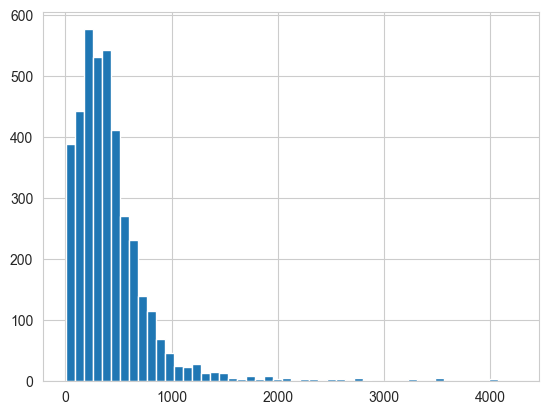

In [18]:
# let take a look at the distribution of pay_per_week
data_df['pay_per_week'].hist(bins=50)

Till this point, we have:

1. categorical variable `family_ses`, which will be the target variable for **supervised learning - classification**
2. numerical variable `income`, which will be the target variable for **supervised learning - regression**
3. text variable `essay`, which will used for **unsupervised learning - topic modeling**. Also, it will serve as the input for the supervised learning models.

Let us take another look at the data.

In [19]:
# check shape
print(data_df.shape)
# preview the data
data_df.head(3)

(3972, 7)


,ID,corrected,readable?,father,financial,pay_per_week,family_ses
0,N10001N,Today is my 25th birthday and I am in hospital...,yes,2.0,2.0,237.25,4.0
3,N10004R,When I am 25 years old. I hope that I will be ...,yes,2.0,2.0,221.25,4.0
12,N10013S,Now that I am 25 and I have left college I thi...,yes,2.0,2.0,729.00,4.0


In [20]:
# create a new dataframe with column corrected, family_ses and pay_per_week from data_df
df = data_df[['corrected', 'family_ses', 'pay_per_week']]

# preview the data
df.head(3)

,corrected,family_ses,pay_per_week
0,Today is my 25th birthday and I am in hospital...,4.0,237.25
3,When I am 25 years old. I hope that I will be ...,4.0,221.25
12,Now that I am 25 and I have left college I thi...,4.0,729.00


In [21]:
# save the dataframe to a new csv file
df.to_csv('cleaned_data.csv', index=False)

Next, we need to preprocess the text data.

## Text Preprocessing

For future classification and regression tasks, I will take an **embedding** approach using word2vec. I will use the `gensim` library to train the word2vec model.


Reference: 
- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification

In [22]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# apply the function to the 'corrected' column
df['essay'] = df['corrected'].apply(preprocess)

/var/folders/zh/79y5ykz51rxcnjchzb73nfxw0000gn/T/ipykernel_47950/889133808.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['essay'] = df['corrected'].apply(preprocess)


In [23]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in df['essay']]
w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)

In [24]:
import numpy as np

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [25]:
essays = np.array([vectorize(sentence) for sentence in df['essay']])

In [26]:
# preview essays
essays[:3]

array([[-0.11246365,  0.17454673,  0.05229707, -0.07233256,  0.05069599,
        -0.57443124,  0.16972995,  0.46120012, -0.4732978 , -0.36397707,
         0.07617242, -0.44332194,  0.40837142, -0.08286877,  0.23994495,
        -0.42285258,  0.17107917, -0.24717905, -0.39495566, -0.70533085,
        -0.11696926,  0.2159124 , -0.05065285, -0.20452781, -0.26111192,
         0.30069923, -0.39004263, -0.2379179 , -0.1738525 ,  0.21246888,
         0.0814508 , -0.10284306, -0.05714114, -0.27530706, -0.44895983,
         0.19428343,  0.13500914, -0.11411589, -0.03180087, -0.6240883 ,
        -0.0506794 , -0.22814904, -0.30290833,  0.03729494,  0.30279124,
         0.00965479, -0.2774558 , -0.21368118,  0.49528036,  0.39825726,
         0.09265195, -0.2785473 , -0.08314785, -0.31763694, -0.24493068,
         0.06045438,  0.05758709, -0.33795574, -0.27210993, -0.12635876,
         0.27698296,  0.08204318,  0.05134289, -0.21362908, -0.44280493,
         0.4693658 , -0.00334883,  0.18466805, -0.4

In [27]:
# put essays back to df
df['essay_vec'] = list(essays)

# preview the data
df.head(3)

/var/folders/zh/79y5ykz51rxcnjchzb73nfxw0000gn/T/ipykernel_47950/208592734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['essay_vec'] = list(essays)


,corrected,family_ses,pay_per_week,essay,essay_vec
0,Today is my 25th birthday and I am in hospital...,4.0,237.25,today 25th birthday hospital first baby child ...,"[-0.112463646, 0.17454673, 0.05229707, -0.0723..."
3,When I am 25 years old. I hope that I will be ...,4.0,221.25,25 years old hope married raising family would...,"[-0.2385876, -0.10725085, 0.21414433, 0.245138..."
12,Now that I am 25 and I have left college I thi...,4.0,729.00,25 left college think go ask interview fire st...,"[-0.1978585, 0.15061136, 0.093836896, 0.134986..."


# Modelling 

In the following sections, I will perform linear regression and polynomial regression to predict income.

In [28]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split

X = np.array(list(df['essay_vec']))
y = df['pay_per_week']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression

I will use the `income` as the target variable and `essay_vec` as the input.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

# score the model
lr.score(X_test, y_test)

0.05473100487503513

In [30]:
from sklearn.metrics import mean_absolute_error

# get mean squared error
y_pred = lr.predict(X_test)
print("The MSE is ",mean_squared_error(y_test, y_pred))        
print("The MAE is ",mean_absolute_error(y_test, y_pred))

The MSE is  177539.26451821125
The MAE is  248.7930324663329


Interpretation: The average squared difference between the actual income (observed values) and the predicted income produced by the model is 175951. The average absolute difference between the actual income (observed values) and the predicted income produced by the model is 244.

Although the prediction is quite off, it is not unreasonable given that the x values are word vectors. There is not a strong linear relationship between the word vectors and income.

### Regarding Feature Importance (Why Skipping this part?)

I decided to use word2vec embedding, and use the means of all word vectors in the essay to represent an essay. 

With this text encoding approach, I cannot extract feature importance, because 1) each feature does not have inherent meaning since it is just a value in the embedding space, 2) as a result of the averaging process, the end vector cannot be mapped to actual words in the original corpus. 

I have stated the problem on [Ed Discussion](https://edstem.org/us/courses/50870/discussion/4286858). 


<span style="color: red;">I have considered TA's suggestion to use TF-IDF and Bag of Words, I also performed the analysis using those two methods. However, the performance is A LOT worse than word2vec. </span>

With the word2vec approach, the performance is not good, but it is the best among all the methods I have tried (with a score close to 0.7) in constrast to the best score of negative values using TF-IDF and Bag of Words.

### Hyperparameter Tuning

Since L1 and L2 regularization can help with overfitting, I will perform grid search to find the best hyperparameters using [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html), which is a combination of L1 and L2 regularization.

In [31]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('regressor', ElasticNet(max_iter= 1000))
])

# Define the grid of hyperparameters to search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'regressor__l1_ratio': [ 0.1, 0.3, 0.5, 0.7, 0.9, 1]  # Balance between L1 and L2
}

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters found
best_parameters = grid_search.best_params_
print("Best parameters: ", best_parameters)

# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e+08, tolerance: 4.481e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e+08, tolerance: 4.102e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best parameters:  {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.9}
Mean Squared Error:  174652.73692280884
Mean Absolute Error:  243.43096786816454


/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e+08, tolerance: 5.412e+04
  model = cd_fast.enet_coordinate_descent(


The best hyperparameters are best_parameters. The mean squared error is 173703 and the mean absolute error is 242. 

This performance after tuning is only marginally better than the untuned linear regression whose mean absolute error is 244. 


## Cross Validation

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define the scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation for MSE
mse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mse_scorer, n_jobs=-1)

# Perform cross-validation for MAE
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer, n_jobs=-1)

# Print out the scores for each fold
print("MSE scores for each fold:")
for i, score in enumerate(mse_scores, start=1):
    print(f"Fold {i}: {score}")

print("\nMAE scores for each fold:")
for i, score in enumerate(mae_scores, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of the scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"\nCross-validated MSE: {mean_mse} ± {std_mse}")
print(f"Cross-validated MAE: {mean_mae} ± {std_mae}")


/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+08, tolerance: 4.481e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e+08, tolerance: 4.523e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

MSE scores for each fold:
Fold 1: -139542.81382732507
Fold 2: -194674.95972784553
Fold 3: -212567.55152602453
Fold 4: -125705.99140880014
Fold 5: -124116.22626799131

MAE scores for each fold:
Fold 1: -228.83965129633907
Fold 2: -239.00417011312047
Fold 3: -262.65813352791633
Fold 4: -221.56461084388567
Fold 5: -221.86192068973745

Cross-validated MSE: -159321.50855159733 ± 37001.673640385365
Cross-validated MAE: -234.78569729419982 ± 15.309113665944027


/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+08, tolerance: 4.481e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e+08, tolerance: 4.561e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

The results from the 5-fold cross-validation show that the MAE values across the folds are relatively consistent, with a mean of approximately -234 and a standard deviation of 15. This indicates a stable model performance across different subsets of the data. 

The mean MAE value (234) is close to the MAE value obtained from the test set (242), which suggests that the model is not overfitting to the training data.

## Polynomial Regression

Due to my limited computational resources and the high dimensionality of my data (word embedding), I will only perform the analysis and tuning for polynomial regression with a degree of 2. 

In [33]:
# fit the model
from sklearn.preprocessing import PolynomialFeatures

poly2 = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly2 = poly2.fit_transform(X_train)
X_test_poly2 = poly2.transform(X_test)

lr_poly2 = LinearRegression()
lr_poly2.fit(X_train_poly2, y_train)

LinearRegression()

In [34]:
# score the model
lr_poly2.score(X_test_poly2, y_test)

-22.262689058352247

In [35]:
# get mean squared error
y_pred = lr_poly2.predict(X_test_poly2)
print("The MSE is ",mean_squared_error(y_test, y_pred))

print("The MAE is ",mean_absolute_error(y_test, y_pred))

The MSE is  4369169.757429424
The MAE is  1409.7787959821796


Interpretation: The average squared difference between the actual income (observed values) and the predicted income produced by the model is 4096385. The average absolute difference between the actual income (observed values) and the predicted income produced by the model is 1407. This model is A LOT worse than the linear regression model, probably due to overfitting.

### Hyperparameter Tuning

In [44]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('regressor', ElasticNet(max_iter= 1000))
])

# Define the grid of hyperparameters to search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength
    'regressor__l1_ratio': [ 0.1, 0.3, 0.5, 0.7, 0.9, 1]  # Balance between L1 and L2
}

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train_poly2, y_train)

# Best parameters found
best_parameters = grid_search.best_params_
print("Best parameters: ", best_parameters)

# Best model
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test_poly2)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e+08, tolerance: 4.481e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e+08, tolerance: 4.102e+04
  model = cd_fast.enet_coordinate_descent(
/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Best parameters:  {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.9}
Mean Squared Error:  173669.02084852647
Mean Absolute Error:  241.31554721634808


/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e+07, tolerance: 5.412e+04
  model = cd_fast.enet_coordinate_descent(


The best hyperparameters are {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.9}. The mean squared error is 173669 and the mean absolute error is 241, which is only marginally better than the untuned linear regression whose mean absolute error is 244, and tuned linear regression whose mean absolute error is 242. However, it is a lot better than the untuned polynomial regression whose mean absolute error is 1407. In this sense, the hyperparameter tuning is effective in reducing overfitting.

Again, I will skip on degree of 3, because my dataset is high-dimensional to begin with, scale it up to degree 3 will make it crazily high-dimensional (taking forever to run on my laptop).

### Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define the scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation for MSE
mse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mse_scorer, n_jobs=-1)

# Perform cross-validation for MAE
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer, n_jobs=-1)

# Print out the scores for each fold
print("MSE scores for each fold:")
for i, score in enumerate(mse_scores, start=1):
    print(f"Fold {i}: {score}")

print("\nMAE scores for each fold:")
for i, score in enumerate(mae_scores, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of the scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"\nCross-validated MSE: {mean_mse} ± {std_mse}")
print(f"Cross-validated MAE: {mean_mae} ± {std_mae}")


MSE scores for each fold:
Fold 1: -138555.44237935529
Fold 2: -194492.4921718515
Fold 3: -213823.75146845297
Fold 4: -126455.07967788943
Fold 5: -126205.56048145675

MAE scores for each fold:
Fold 1: -227.19167796028677
Fold 2: -242.46270045240624
Fold 3: -259.6976733812486
Fold 4: -222.75178218934747
Fold 5: -224.44748630781692

Cross-validated MSE: -159906.46523580118 ± 36915.79436484291
Cross-validated MAE: -235.3102640582212 ± 14.053682274740872


The results from the 5-fold cross-validation show that the MAE values across the folds are relatively consistent, with a mean of approximately -234 and a standard deviation of 14. This indicates a stable model performance across different subsets of the data. 

The mean MAE value (235) is close to the MAE value obtained from the test set (241), which suggests that the model is not overfitting too bad to the training data.

## Decision Tree Regression

In [38]:
from sklearn.tree import DecisionTreeRegressor

# build the model
reg = DecisionTreeRegressor(random_state=42, max_depth=25, min_samples_leaf=5, min_samples_split=5)
reg.fit(X_train, y_train)

# make predictions
y_pred = reg.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  254689.63916693116
Mean Absolute Error:  312.351343811674


This performance is not bad compared to the untuned polynomial regression, however, it is still worse than the tuned linear regression and tuned polynomial regression. Let us see if hyperparameter tuning can improve the performance.

### Hyperparameter Tuning

In [39]:
# Define the parameters grid
param_grid = {
    'max_depth': [5, 10, 20, 30, 40],  
    'min_samples_leaf': [4, 6, 8, 10, 20],
    'min_samples_split': [0, 1, 2, 5, 10, 15]
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_model = grid_search.best_estimator_

# Use the best estimator to make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/mhhuang/anaconda3/envs/ContentAnalysis/lib/python3.9/site-packages/sklearn/

Best parameters: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Mean Squared Error:  180243.76625600245
Mean Absolute Error:  255.82310671721748


Okay, the best hyperparameters are {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}. The mean squared error is 180243, and the mean absolute error is 255. 
The tuning does improve the result of RFR from the untuned one.

However, this performance is not as good as the tuned linear regression (MAE = 244) and tuned polynomial regression (MAE = 242).

### Cross Validation

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Define the scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation for MSE
mse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mse_scorer, n_jobs=-1)

# Perform cross-validation for MAE
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer, n_jobs=-1)

# Print out the scores for each fold
print("MSE scores for each fold:")
for i, score in enumerate(mse_scores, start=1):
    print(f"Fold {i}: {score}")

print("\nMAE scores for each fold:")
for i, score in enumerate(mae_scores, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of the scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"\nCross-validated MSE: {mean_mse} ± {std_mse}")
print(f"Cross-validated MAE: {mean_mae} ± {std_mae}")


MSE scores for each fold:
Fold 1: -138555.44237935529
Fold 2: -194492.4921718515
Fold 3: -213823.75146845297
Fold 4: -126455.07967788943
Fold 5: -126205.56048145675

MAE scores for each fold:
Fold 1: -227.19167796028677
Fold 2: -242.46270045240624
Fold 3: -259.6976733812486
Fold 4: -222.75178218934747
Fold 5: -224.44748630781692

Cross-validated MSE: -159906.46523580118 ± 36915.79436484291
Cross-validated MAE: -235.3102640582212 ± 14.053682274740872


The results from the 5-fold cross-validation show that the MAE values across the folds are relatively consistent, with a mean of approximately 235 and a standard deviation of 15. This indicates a stable model performance across different subsets of the data.

The mean MAE value (235) is close to the MAE value obtained from the test set (255), which suggests that the model is not overfitting to the training data.

## Random Forest Regression

In [41]:
from sklearn.ensemble import RandomForestRegressor

# build the model
reg = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=25, min_samples_leaf=5, min_samples_split=5)
reg.fit(X_train, y_train)

# evaluate the model
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)

Mean Squared Error:  176375.86487140902
Mean Absolute Error:  250.30166019854212


Just like the decision tree regression, the performance of random forest regression is not as good as the tuned linear regression and tuned polynomial regression. 

Let us see if hyperparameter tuning can improve the performance. This time, I will use `RandomizedSearchCV` instead of `GridSearchCV` to speed up the process.

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Define the model
reg = RandomForestRegressor(random_state=42)

# Define the parameters grid
param_distributions = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # Maximum depth of the tree
    'min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required at each leaf node
    'min_samples_split': [2, 5, 10, 15]  # Minimum number of samples required to split an internal node
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=reg, param_distributions=param_distributions, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Use the best estimator to make predictions
y_pred = random_search.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)


Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_depth': 10}
Mean Squared Error:  175892.7232391635
Mean Absolute Error:  248.20616437582586


### Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Assuming you have the RandomForestRegressor imported
from sklearn.ensemble import RandomForestRegressor

# Best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Define the scorers
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform cross-validation for MSE
mse_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mse_scorer, n_jobs=-1)

# Perform cross-validation for MAE
mae_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=mae_scorer, n_jobs=-1)

# Print out the scores for each fold
print("MSE scores for each fold:")
for i, score in enumerate(mse_scores, start=1):
    print(f"Fold {i}: {score}")

print("\nMAE scores for each fold:")
for i, score in enumerate(mae_scores, start=1):
    print(f"Fold {i}: {score}")

# Calculate and print the mean and standard deviation of the scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
mean_mae = mae_scores.mean()
std_mae = mae_scores.std()

print(f"\nCross-validated MSE: {mean_mse} ± {std_mse}")
print(f"Cross-validated MAE: {mean_mae} ± {std_mae}")

MSE scores for each fold:
Fold 1: -140854.73883754254
Fold 2: -195320.16255478212
Fold 3: -215194.79239033107
Fold 4: -127871.51827313837
Fold 5: -131489.88993002262

MAE scores for each fold:
Fold 1: -235.4194172976302
Fold 2: -245.7676737628672
Fold 3: -261.95829433708866
Fold 4: -229.74263012144277
Fold 5: -231.13265526556606

Cross-validated MSE: -162146.22039716336 ± 36007.09490974298
Cross-validated MAE: -240.80413415691896 ± 11.975180745822115


The results from the 5-fold cross-validation show that the MAE values across the folds are relatively consistent, with a mean of approximately 240 and a standard deviation of 11. This indicates a stable model performance across different subsets of the data.

The mean MAE value (240) is close to the MAE value obtained from the test set (248), which suggests that the model is not overfitting to the training data.

# Summary and Conclusion

Comparing across 4 models, **after hyperparameter tuning**, they all have **similar performance**. The mean absolute error (MAE) is 243, 241, 255, 250 for linear regression, polynomial regression, decision tree regression, and random forest regression, respectively.

Also, the **cross-validation** results show that the MAE values across the folds are relatively consistent, with a mean of approximately 235-240 and a standard deviation of 11-15. This indicates a stable model performance across different subsets of the data and across models, which is very impressive given the high dimensionality of the data.

Given the simplicity of linear regression and the similar performance across models, I would recommend using linear regression (with regularization) for predicting income based on the essays.